# Выделение групп пользователей мобильного приложения на основе поведения

**Цель исследования:** Выделить сегменты пользователей для управления вовлеченностью (адаптировать приложение под целевую и смежные аудитории). Получить на основе сегментации гипотезы о том, как можно улучшить приложение с точки зрения пользовательского опыта.

**Задачи исследования:** 
- выяснить, пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate);
- выяснить, пользователи какой группы чаще совершают целевое действие (просмотр контактов).

## План работы

1. Загрузка и предобработка данных<br/>
	1.1. Изменение типов данных<br/>
	1.2. Обработка дубликатов<br/>
	1.3. Знакомство с данными<br/>
	1.4. Объединение и категоризация данных<br/>
2. Исследовательский анализ данных<br/>
	2.1. Выделение пользовательских сессий<br/>
	2.2. Получение профилей пользователей<br/>
	2.3. Расчет Retention Rate<br/>
	2.4. Анализ времени, проведенного в приложении<br/>
	2.5. Анализ частоты действий<br/>
	2.6. Конверсия в целевое действие (contacts_show)<br/>
3. Сегментация пользователей на группы<br/>
	3.1. Разделение по источнику привлечения<br/>
		3.1.1. Retention Rate<br/>
		3.1.2. Конверсия<br/>
	3.2. Разделение по времени, проведенному в приложении<br/>
		3.2.1. Retention Rate<br/>
		3.2.2. Конверсия<br/>
4. Проверка статистических гипотез<br/>
	4.1. Сравнение групп пользователей по источнику установки приложения<br/>
	4.2. Сравнение групп пользователей по времени, проведенному в приложении<br/>
5. Выводы и рекомендации<br/>

## 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [2]:
mobile_sources = pd.read_csv('/datasets/mobile_sources.csv')
mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')

In [3]:
mobile_sources.info()
mobile_sources.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_dataset.info()
mobile_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


### 1.1. Изменение типов данных

In [5]:
# приведем названия столбцов к более удобному виду
mobile_sources.columns = ['user_id', 'source']
mobile_dataset.columns = ['event_time', 'event_name', 'user_id']

In [6]:
# преобразуем тип данных в колонке event_time
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

### 1.2. Обработка дубликатов

In [7]:
# проверим датасеты на явные дубликаты
print(mobile_sources.duplicated().sum())
print(mobile_dataset.duplicated().sum())

0
0


In [8]:
# проверим датасеты на неявные дубликаты
print(mobile_sources.duplicated(['user_id']).sum())
print(mobile_dataset.duplicated(['event_time', 'user_id']).sum())

0
0


### 1.3. Знакомство с данными

In [9]:
# посмотрим, данными за какой период мы располагаем
print(mobile_dataset['event_time'].min())
print(mobile_dataset['event_time'].max())

2019-10-07 00:00:00.431357
2019-11-03 23:58:12.532487


In [10]:
# посмотрим, информацию о каком количестве пользователей содержат датасеты
print(mobile_sources['user_id'].nunique())
print(mobile_dataset['user_id'].nunique())

4293
4293


In [11]:
# посмотрим, из каких источников приходят пользователи
print(mobile_sources['source'].unique())

['other' 'yandex' 'google']


In [12]:
# посмотрим, какие типы событий совершают пользователи
print(mobile_dataset['event_name'].unique())

['advert_open' 'tips_show' 'map' 'contacts_show' 'search_4' 'search_5'
 'tips_click' 'photos_show' 'search_1' 'search_2' 'search_3'
 'favorites_add' 'contacts_call' 'search_6' 'search_7' 'show_contacts']


### 1.4. Объединение и категоризация данных

In [13]:
# объединим события search_1-search_7 в одно событие search,
# а также contacts_show и show_contacts, т.к. эти события равнозначны

replace_list = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']

mobile_dataset.loc[mobile_dataset['event_name'].isin(replace_list), 'event_name'] = 'search'
mobile_dataset.loc[mobile_dataset['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'

In [14]:
# объединим два датасета
data = mobile_dataset.merge(mobile_sources, on='user_id', how='left')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


### 1.5. Вывод

Датасеты содержат информацию о 74197 событиях, совершенных 4293 пользователями за 4 недели с 7 октября 2019 по 3 ноября 2019.
В данных отсутствуют дубликаты и пропуски. В результате предобработки мы получили датасет со следующими колонками:
- `event_time` — время совершения
- `event_name` — название события
- `user_id` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search` — события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

## 2. Исследовательский анализ данных

### 2.1. Выделение пользовательских сессий

Необходимо выделить пользовательские сессии, так как в исходных данных эта информация отсутствует. В системах веб-аналитики сессия заканчивается, когда в течение определённого времени пользователь не совершает новых действий. В Google Analytics и Яндекс.Метрика по умолчанию это 30 минут.

In [15]:
# устанавливаем таймаут в секундах
timeout = 1800

# отсортируем датасет по user_id и времени события
data = data.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)

In [16]:
# считаем паузу между действиями пользователя в секундах
data['duration'] = data['event_time'] - data['event_time'].shift(1)
data['duration'] = data['duration'].fillna(pd.Timedelta(seconds=0))
data['duration'] = data['duration'].apply(lambda x: x.seconds)

# отмечаем начало каждой новой сессии флагом Start
data['flag'] = np.where(
    (data['user_id'] != data['user_id'].shift(1)) | (data['duration'] > timeout), 
    'Start', 0
)

# выбираем строки с флагом Start, добавляем столбец с кумулятивной суммой количества значений
session_id = data[data['flag'] == 'Start'].groupby('flag').cumcount() + 1

# объединяем датасеты
data = pd.concat([data, session_id],  axis=1)

# переименовываем присоединенный столбец и удаляем вспомогательные
data = data.rename(columns = {data.columns[-1]: 'session_id'})
data.drop(columns=['duration', 'flag'], axis= 1, inplace=True)

# заполненяем Nan'ы предыдущим не Nan значением
data['session_id'].ffill(inplace=True)

In [17]:
# посмотрим получившееся количество сессий
data['session_id'].nunique()

10231

In [18]:
data.head(15)

,event_time,event_name,user_id,source,session_id
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
5,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
6,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
7,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
8,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1.0
9,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2.0


### 2.2. Получение профилей пользователей

In [19]:
# выделяем время начала каждой сессии
session_start = (
    data.sort_values(by=['user_id', 'event_time'])
    .groupby(by='session_id')
    .agg({'user_id': 'first', 'source': 'first', 'event_time': 'min'})
    .rename(columns={'event_time': 'session_start'})
    .reset_index()
)

# дополняем профили временем окончания сессии
session_end = (
    data.sort_values(by=['user_id', 'event_time'])
    .groupby(by='session_id')
    .agg({'event_time': 'max'})
    .rename(columns={'event_time': 'session_end'})
    .reset_index()
)

# дополняем профили данными о первых визитах
first_ts = (
    data.sort_values(by=['user_id', 'event_time'])
    .groupby(by='user_id')
    .agg({'event_time': 'min'})
    .rename(columns={'event_time': 'first_ts'})
    .reset_index()
)
first_ts['first_dt'] = first_ts['first_ts'].dt.date

# объединяем таблицы
profiles = session_start.merge(first_ts, on='user_id', how='left')
profiles = profiles.merge(session_end, on='session_id', how='left')

# вычисляем длительность сессий
profiles['duration_sec'] = (
    profiles['session_end'] - profiles['session_start']
).apply(lambda x: x.seconds)

# вычисляем лайфтайм для каждой сессии в днях
profiles['lifetime'] = (
    profiles['session_start'] - profiles['first_ts']
).dt.days

profiles.head()

,session_id,user_id,source,session_start,first_ts,first_dt,session_end,duration_sec,lifetime
0,1.0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,2019-10-07 13:39:45.989359,2019-10-07,2019-10-07 13:49:41.716617,595,0
1,2.0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-09 18:33:55.577963,2019-10-07 13:39:45.989359,2019-10-07,2019-10-09 18:42:22.963948,507,2
2,3.0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-21 19:52:30.778932,2019-10-07 13:39:45.989359,2019-10-07,2019-10-21 20:07:30.051028,899,14
3,4.0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-22 11:18:14.635436,2019-10-07 13:39:45.989359,2019-10-07,2019-10-22 11:30:52.807203,758,14
4,5.0,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:33.849769,2019-10-19 21:34:33.849769,2019-10-19,2019-10-19 21:59:54.637098,1520,0


### 2.3. Расчет Retention Rate

In [20]:
# строим таблицу удержания
retention = profiles.pivot_table(
    index=['first_dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)

# вычисляем размеры когорт
cohort_sizes = (
    profiles.groupby('first_dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# объединяем размеры когорт и таблицу удержания
retention = cohort_sizes.merge(
    retention, on='first_dt', how='left'
).fillna(0)

# делим данные таблицы удержания на размеры когорт
retention = retention.div(
    retention['cohort_size'], axis=0
).drop(columns=['cohort_size'])

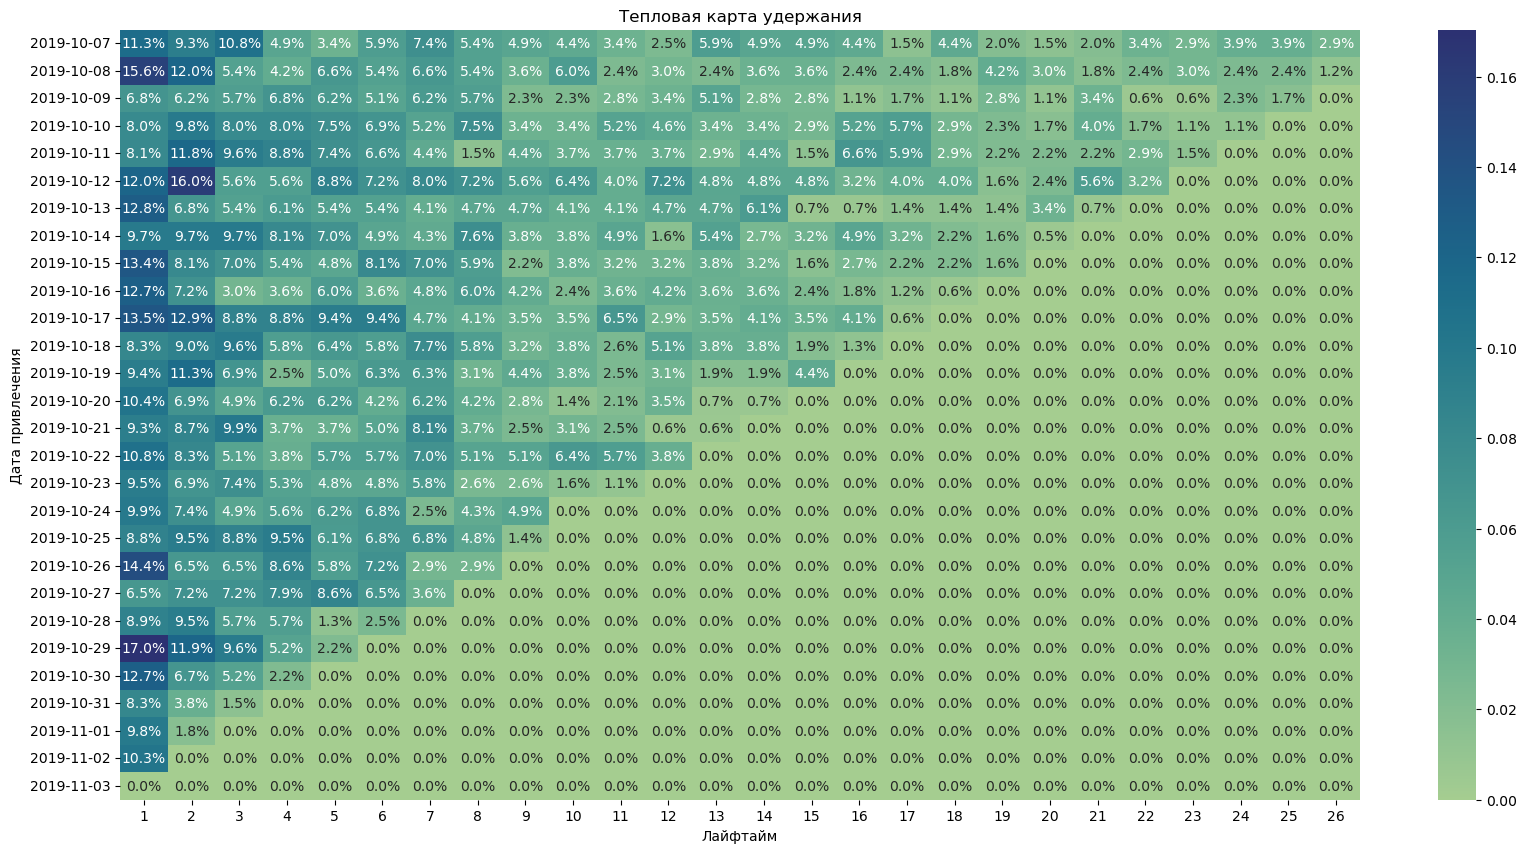

In [21]:
# визуализируем итог на тепловой карте
plt.figure(figsize=(20, 10))
sns.heatmap(
    retention.drop(columns=0),  
    annot=True,  
    fmt='.1%',
    cmap='crest'
)
plt.title('Тепловая карта удержания')
plt.xlabel('Лайфтайм')
plt.ylabel('Дата привлечения')

plt.show()

График Retention Rate демонстрирует, какая часть пользователей, зарегистрировавшихся в приложении в определенный день (называемый когортой), продолжила использовать приложение в последующие дни. 

Мы можем видеть, что в начале периода (первые несколько дней после регистрации) удержание составляет около 10%, но затем оно постепенно снижается. Тем не менее, после некоторого периода спада, удержание повторно увеличивается. Например, в когорте, зарегистрированной 11 октября, мы видим, что удержание на 17-й день составляет примерно 6%, в то время как на 7-й день оно было около 4%. Это может свидетельствовать о том, что пользователи имеют тенденцию возвращаться к использованию приложения после перерыва.

Также стоит обратить внимание на то, что показатели удержания в первые дни довольно низкие, что может указывать на необходимость улучшения пользовательского опыта или на проблемы в приложении, связанные с его функционалом или удобством использования.

### 2.4. Анализ времени, проведенного в приложении

In [22]:
# посчитаем среднюю длину сессии для каждого пользователя
time = (
    profiles.groupby('user_id')
    .agg({'duration_sec': 'mean'})
    .rename(columns={'duration_sec': 'avg_duration'})
    .reset_index()
)
time['avg_duration'] = time['avg_duration']/60

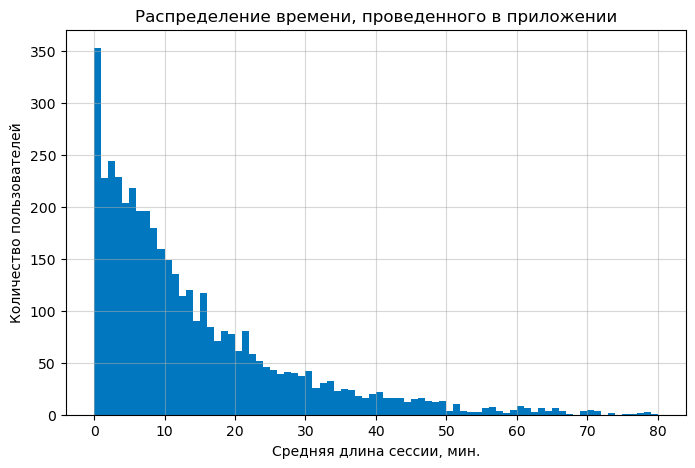

In [23]:
# создание гистограммы
plt.figure(figsize=(8, 5))
plt.hist(time['avg_duration'], bins=80, range=[0, 80], color='#0077be')
plt.grid(alpha=0.5)

plt.xlabel('Средняя длина сессии, мин.')
plt.ylabel('Количество пользователей')
plt.title('Распределение времени, проведенного в приложении')

plt.show()

Самый первый пик на гистограмме говорит о том, что у многих пользователей средняя длительность сессии составляет около 1 минуты. Если учесть, что на второй день в приложение возвращаются только около 10% пользователей, то это может говорить о проблемах в приложении. Например, пользователи могут быстро уходить из приложения, если они не находят то, что искали, если интерфейс приложения неудобен, или если приложение не работает должным образом. Поэтому важно проанализировать, что происходит в приложении в течение первой минуты, чтобы определить, есть ли проблемы, которые нужно решить.

По остальному же графику можно заметить, что большинство пользователей проводят в приложении от 1 до 10 минут в среднем, причем пик находится около 2-3 минут. Кроме того, на графике присутствует длинный хвост справа, который говорит о том, что некоторые пользователи проводят в приложении очень много времени (вплоть до нескольких часов). Чтобы более точно оценить распределение, можно использовать график "ящик с усами", который выявляет выбросы и экстремальные значения.

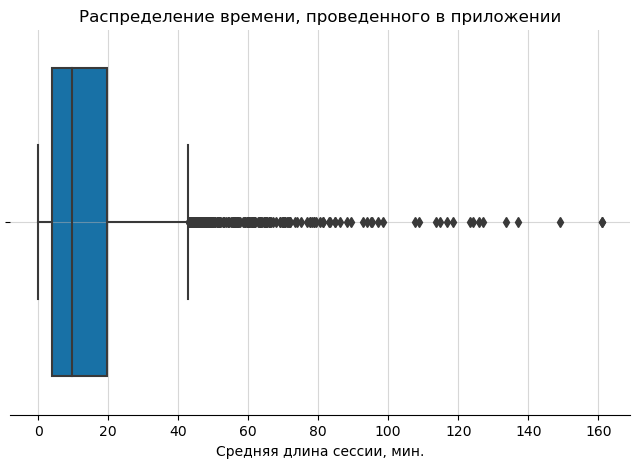

In [24]:
# создание графика "ящик с усами"
plt.figure(figsize=(8, 5))
sns.boxplot(data=time, x='avg_duration', color='#0077be')
sns.despine(left=True)
plt.xlabel('Средняя длина сессии, мин.')
plt.title('Распределение времени, проведенного в приложении')
plt.grid(alpha=0.5)
plt.show()

На графике видно, что большинство пользователей проводят в приложении от 1 до 10 минут, медианное значение около 4 минут. Есть несколько выбросов, которые указывают на наличие экстремально длительных сессий в приложении, которые можно дополнительно изучить, чтобы понять, что приводит к такому поведению пользователей. Возможно как наличие технических проблем, так и вовлеченность отдельных пользователей.

### 2.5. Анализ частоты действий

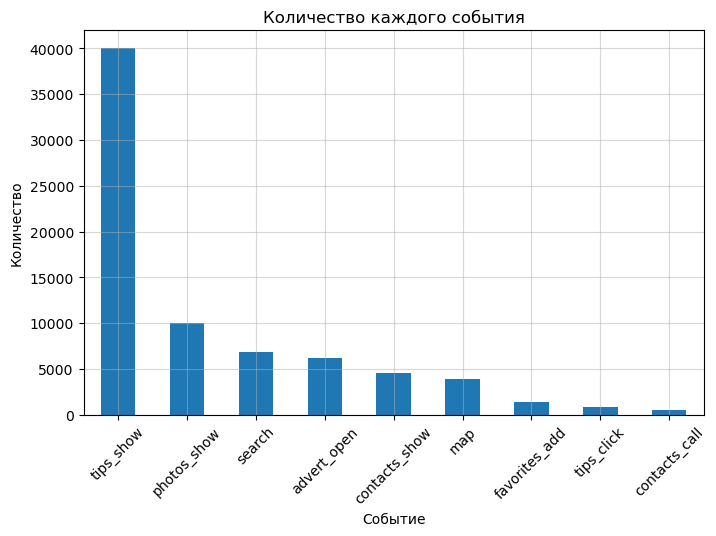

In [25]:
# расчет количества каждого события
event_counts = data['event_name'].value_counts()

# построение графика
plt.figure(figsize=(8, 5))
event_counts.plot(kind='bar')
plt.title('Количество каждого события')
plt.xlabel('Событие')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.show()

Большинство событий связаны с просмотром объявлений и поиском информации (advert_open, photos_show, tips_show, map, search). Количество событий, связанных с контактами пользователей (contacts_show, contacts_call), значительно меньше. Количество событий, связанных с добавлением объявлений в избранное (favorites_add) и кликами по рекомендованным объявлениям (tips_click), также невелико. Возможно, стоит обратить внимание на возможность увеличения вовлеченности пользователей в эти события.

Анализ частоты действий по дням недели также может помочь выявить паттерны поведения пользователей в разные дни и определить, какие дни недели наиболее активны для пользователей приложения.

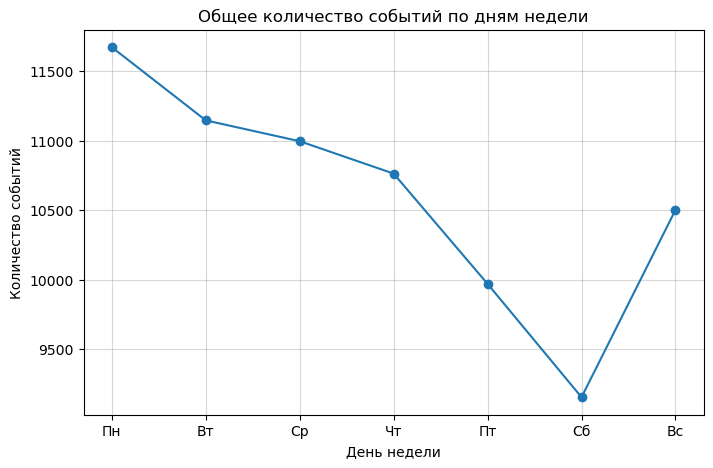

In [26]:
# добавление столбца с днем недели
data['weekday'] = data['event_time'].dt.weekday

# группировка по дню недели
events_by_weekday = data.groupby('weekday')['event_name'].count().reset_index()

# отрисовка графика
plt.figure(figsize=(8, 5))
plt.plot(events_by_weekday['weekday'], events_by_weekday['event_name'], marker='o')
plt.xticks(np.arange(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.xlabel('День недели')
plt.ylabel('Количество событий')
plt.title('Общее количество событий по дням недели')
plt.grid(alpha=0.5)
plt.show()

По графику видно, что наибольшее количество событий происходит в понедельник, затем наблюдается постепенное снижение активности пользователей в течение недели. В субботу наблюдается наименьшее число событий, а в воскресенье активность пользователей снова начинает расти. Эта тенденция может быть связана с тем, что в понедельник пользователи возвращаются к работе после выходных и активно начинают использовать приложение, а к концу недели и особенно в выходные дни пользователи могут заниматься другими делами и меньше времени уделять приложению.

### 2.6. Конверсия в целевое действие (contacts_show)

Расчет конверсии пользователей в целевое действие позволяет оценить эффективность приложения в целом и понять, насколько хорошо оно привлекает и удерживает пользователей. Это может быть полезно при оптимизации приложения.

In [27]:
# количество уникальных пользователей, которые совершили действие contacts_show
contacts_show_users = data.query('event_name == "contacts_show"')['user_id'].nunique()

# общее количество уникальных пользователей, которые совершили любое действие в приложении
total_users = data['user_id'].nunique()

# конверсия пользователей в целевое действие (contacts_show)
conversion_rate = contacts_show_users / total_users

print('Конверсия пользователей в целевое действие: {:.2%}'.format(conversion_rate))

Конверсия пользователей в целевое действие: 22.85%


Менее четверти всех пользователей проявляют интерес к контактам продавцов. Для увеличения конверсии можно анализировать факторы, влияющие на поведение пользователей на сайте и принимать меры для оптимизации процесса принятия решения о просмотре контактов продавца, например, упростить и ускорить процесс получения необходимой информации.

### 2.7. Вывод

В результате проведенного исследовательского анализа данных можно сделать следующие выводы о поведении пользователей:

- Показатели удержания в первые дни довольно низкие.
- Пользователи имеют тенденцию возвращаться к использованию приложения после перерыва.
- Большинство пользователей проводят в приложении от 1 до 10 минут, медианное значение около 4 минут.
- Большинство пользователей приложения проявляют интерес к объявлениям и поиску информации о них; количество событий, связанных с контактами продавцов, значительно меньше.
- Наибольшее количество событий происходит в начале недели, а к концу недели и особенно в выходные дни активность пользователей снижается.
- Конверсия пользователей в целевое действие (просмотр контактов продавца) составляет 22.85%.

Следует уделить больше внимания удержанию пользователей в первые дни использования приложения. Для увеличения времени использования приложения можно упростить и ускорить процесс получения необходимой информации. Следует обратить внимание на поведение пользователей после перерыва и предложить им персонализированный контент, который может заинтересовать. Для увеличения конверсии в целевое действие можно оптимизировать процесс принятия решения о просмотре контактов продавца.

## 3. Сегментация пользователей на группы

Выбор признака, по которому делят пользователей, зависит от цели исследования и гипотез, которые нужно проверить. В данном случае было выбрано разделение по источнику привлечения и по времени, проведенному в приложении. Для этого есть несколько причин:
- Деление по источнику привлечения помогает понять, какие каналы привлечения наиболее эффективны и какие нуждаются в дополнительной оптимизации. Например, если пользователи, привлеченные через социальные сети, имеют более высокую конверсию, чем те, кто пришел из поисковых систем, то можно сделать вывод о том, что следует увеличить бюджет на рекламу в социальных сетях.
- Деление по времени, проведенному в приложении, может помочь понять, какие пользователи являются наиболее активными, какие проблемы у пользователей, проводящих в приложении мало времени, и как увеличить их удержание. Например, если пользователи, проводящие в приложении более 10 минут, имеют более высокую конверсию, то можно предложить определенные функции или возможности, которые заставят пользователей проводить больше времени в приложении.

Исследование таких групп пользователей позволит более точно настроить маркетинговую стратегию, улучшить пользовательский опыт и увеличить конверсию в целевые действия, что, в конечном итоге, может повысить доходность бизнеса.

### 3.1. Разделение по источнику привлечения

Разделение пользователей на группы по источнику привлечения позволяет оценить эффективность маркетинговых каналов и понять, какие источники привлечения приносят больше пользователей и какие наиболее эффективны в привлечении целевой аудитории. 

#### 3.1.1. Retention Rate

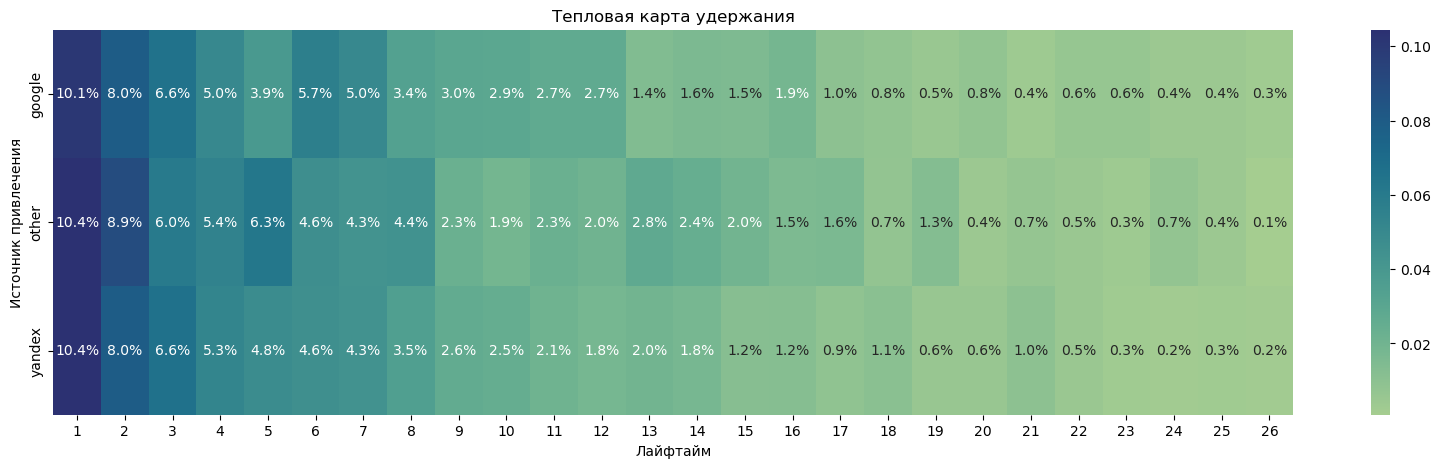

In [28]:
# строим таблицу удержания
retention_by_source = profiles.pivot_table(
    index=['source'], columns='lifetime', values='user_id', aggfunc='nunique'
)

# вычисляем размеры когорт
cohort_sizes = (
    profiles.groupby('source')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# объединяем размеры когорт и таблицу удержания
retention_by_source = cohort_sizes.merge(
    retention_by_source, on='source', how='left'
).fillna(0)

# делим данные таблицы удержания на размеры когорт
retention_by_source = retention_by_source.div(
    retention_by_source['cohort_size'], axis=0
).drop(columns=['cohort_size'])

# визуализируем итог на тепловой карте
plt.figure(figsize=(20, 5))
sns.heatmap(
    retention_by_source.drop(columns=0),  
    annot=True,  
    fmt='.1%',
    cmap='crest'
)
plt.title('Тепловая карта удержания')
plt.xlabel('Лайфтайм')
plt.ylabel('Источник привлечения')

plt.show()

На графике видно, что удержание довольно низкое во всех группах и стремительно снижается уже после первой недели использования приложения. Это может говорить о том, что пользователи быстро теряют интерес к приложению и перестают его использовать.

Кроме того, на графике не видно существенных различий между группами пользователей по источникам привлечения. Это может означать, что эффективность разных каналов привлечения пользователей примерно одинакова, но удержание низкое в любом случае.

#### 3.1.2. Конверсия

In [29]:
# количество уникальных пользователей в каждой группе, которые совершили действие contacts_show
contacts_show_users_by_source = data.query('event_name == "contacts_show"') \
                                    .groupby('source') \
                                    .agg({'user_id': 'nunique'}) \
                                    .reset_index()

# общее количество уникальных пользователей в каждой группе
total_users_by_source = data.groupby('source').agg({'user_id': 'nunique'}).reset_index()

# конверсия пользователей в целевое действие (contacts_show)
conversion_by_source = total_users_by_source.merge(
    contacts_show_users_by_source, on='source', how='left'
).rename(columns={'user_id_x': 'total_users', 'user_id_y': 'contacts_show_users'})

conversion_by_source['conversion'] = (
    conversion_by_source['contacts_show_users'] / conversion_by_source['total_users']
).map(lambda x: '{:.2%}'.format(x))

conversion_by_source.sort_values('conversion', ascending=False)[['source', 'conversion']]

,source,conversion
2,yandex,24.72%
0,google,24.36%
1,other,18.54%


Группы пользователей, привлеченные через Google и Yandex, имеют примерно одинаковую конверсию, но Yandex немного опережает Google. Однако, стоит проверить, является ли эта разница статистически значимой. При этом прочие источники привлечения показывают самую низкую конверсию.

### 3.2. Разделение по времени, проведенному в приложении

Разделение пользователей по времени, проведенном в приложении, позволит проанализировать, какие группы имеют более высокие показатели удержания и конверсию. Эта информация может помочь в оптимизации маркетинговой стратегии, улучшения качества взаимодействия с пользователями и улучшения эффективности приложения в целом.

Разделим пользователей на 4 группы:
- Пользователи, проводящие в приложении менее 1 минуты.
- Пользователи, проводящие в приложении от 1 до 5 минут.
- Пользователи, проводящие в приложении от 5 до 15 минут.
- Пользователи, проводящие в приложении более 15 минут.

In [30]:
# ранее мы считали среднюю длину сессии для каждого пользователя,
# она записана в переменной time
time.head()

,user_id,avg_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,11.495833
1,00157779-810c-4498-9e05-a1e9e3cedf93,32.697222
2,00463033-5717-4bf1-91b4-09183923b9df,24.700000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,18.450000
4,00551e79-152e-4441-9cf7-565d7eb04090,3.105556


In [31]:
# напишем функцию, которая разделит пользователей на группы
def time_group(time):
    """
    Возвращает группу по времени, проведенному в приложении, используя правила:
    - 'минимальное время', если time <= 1 мин;
    - 'низкое время', если time от 1 до 5 мин;
    - 'среднее время', если time от 5 до 15 мин;
    - 'высокое время' - от 15 мин и выше.
    """
    
    if time <= 1:
        return 'минимальное время'
    if time <= 5:
        return 'низкое время'
    if time <= 15:
        return 'среднее время'
    return 'высокое время' 

In [32]:
# создадим столбец с категориями времени
time['time_group'] = time['avg_duration'].apply(time_group)

# добавляем эту информацию в профили
profiles = profiles.merge(time, on='user_id', how='left')

#### 3.2.1. Retention Rate

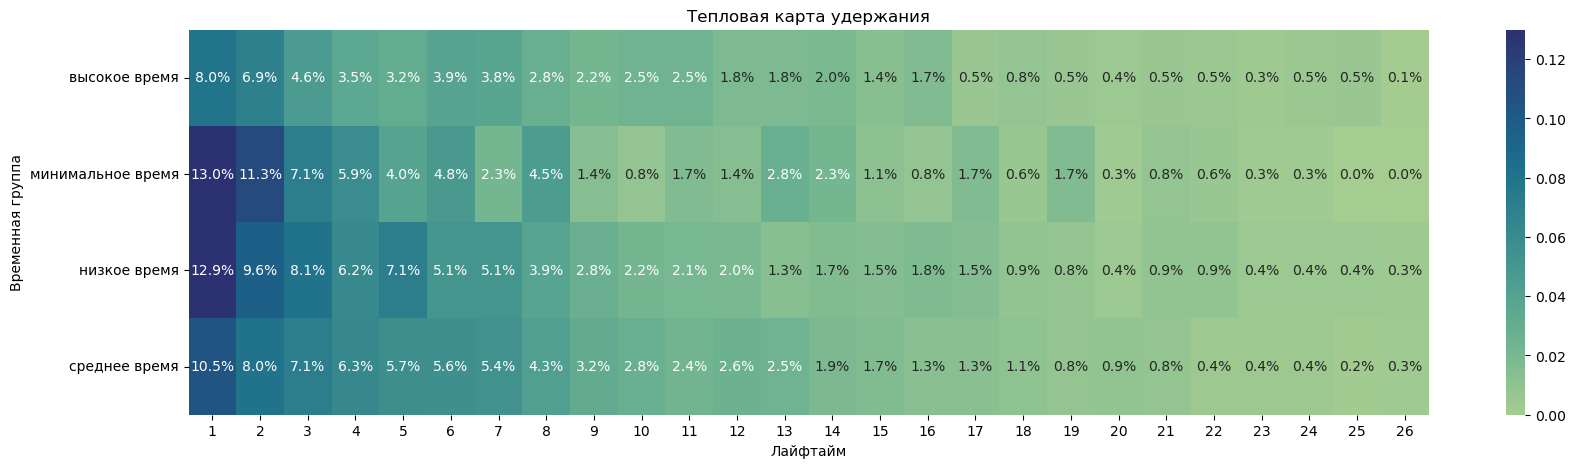

In [33]:
# строим таблицу удержания
retention_by_time = profiles.pivot_table(
    index=['time_group'], columns='lifetime', values='user_id', aggfunc='nunique'
)

# вычисляем размеры когорт
cohort_sizes = (
    profiles.groupby('time_group')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# объединяем размеры когорт и таблицу удержания
retention_by_time = cohort_sizes.merge(
    retention_by_time, on='time_group', how='left'
).fillna(0)

# делим данные таблицы удержания на размеры когорт
retention_by_time = retention_by_time.div(
    retention_by_time['cohort_size'], axis=0
).drop(columns=['cohort_size'])

# визуализируем итог на тепловой карте
plt.figure(figsize=(20, 5))
sns.heatmap(
    retention_by_time.drop(columns=0),  
    annot=True,  
    fmt='.1%',
    cmap='crest'
)
plt.title('Тепловая карта удержания')
plt.xlabel('Лайфтайм')
plt.ylabel('Временная группа')

plt.show()

Удержание пользователей ухудшается со временем у любой группы. Пользователи, которые продолжают пользоваться приложением в течение нескольких дней или недель, становятся все менее активными.

Удержание пользователей, которые проводят в приложении более 15 минут, хуже, чем удержание остальных групп пользователей. Вероятно, такие пользователи уже достигли своих целей в приложении и не больше не видят смысла в его использовании.

Плавное снижение удержания пользователей от 5-15 минут и 1-5 минут может говорить о том, что такие пользователи могут быть более стабильными и менее склонны к переходу на другие приложения, в то время как удержание пользователей менее 1 минуты может иметь скачки из-за того, что такие пользователи имеют более непостоянное поведение и могут быть более склонны к переходу на другие приложения.

#### 3.2.2. Конверсия

In [34]:
# добавляем информацию о временной группе в общий датасет
data = data.merge(time, on='user_id', how='left')

In [35]:
# количество уникальных пользователей в каждой группе, которые совершили действие contacts_show
contacts_show_users_by_time = data.query('event_name == "contacts_show"') \
                                    .groupby('time_group') \
                                    .agg({'user_id': 'nunique'}) \
                                    .reset_index()

# общее количество уникальных пользователей в каждой группе
total_users_by_time = data.groupby('time_group').agg({'user_id': 'nunique'}).reset_index()

# конверсия пользователей в целевое действие (contacts_show)
conversion_by_time = total_users_by_time.merge(
    contacts_show_users_by_time, on='time_group', how='left'
).rename(columns={'user_id_x': 'total_users', 'user_id_y': 'contacts_show_users'})

conversion_by_time['conversion'] = (
    conversion_by_time['contacts_show_users'] / conversion_by_time['total_users']
).map(lambda x: '{:.2%}'.format(x))

conversion_by_time.sort_values('conversion', ascending=False)[['time_group', 'conversion']]

,time_group,conversion
0,высокое время,25.08%
3,среднее время,22.21%
2,низкое время,21.63%
1,минимальное время,19.49%


Пользователи, проводящие более 15 минут в приложении, имеют наибольшую конверсию в просмотр контактов - 25.08%, что может указывать на более высокую заинтересованность в продаже или покупке товаров.

Конверсия уменьшается по мере уменьшения времени, проведенного в приложении. Возможно, это связано с тем, что они не успевают понять все возможности и преимущества приложения, и, следовательно, не получают достаточно стимулов для продолжения использования.

Необходимо проверить гипотезу о том, что пользователи, которые проводят больше времени в приложении, действительно лучше конвертируются в целевое действие.

### 3.3. Вывод

Исходя из результатов разделения пользователей по источнику привлечения, можно сделать вывод, что конверсия примерно одинакова для Google и Yandex - эту группу пользователей можно считать целевой. Прочие источники привлечения показывают более низкую конверсию, а значит эта группа может рассматриваться как смежная.

При разделении пользователей по времени, проведенному в приложении, наибольшую конверсию в просмотр контактов имеют пользователи, проводящие более 15 минут в приложении. Следовательно, эта группа пользователей может рассматриваться как потенциально наиболее ценная для бизнеса. Остальные группы пользователей (проводящие от 5 до 15 минут, от 1 до 5 минут и менее 1 минуты в приложении) могут рассматриваться как смежные.

Однако, следует учитывать, что все группы пользователей имеют проблемы с удержанием, и необходимо проводить дополнительное исследование, чтобы выяснить, как можно увеличить удержание пользователей и сделать приложение более привлекательным для пользователей.

## 4. Проверка статистических гипотез

### 4.1. Сравнение групп пользователей по источнику установки приложения

**Нулевая гипотеза (H0):** конверсия в просмотр контактов не зависит от источника установки приложения (yandex или google).

**Альтернативная гипотеза (H1):** конверсия в просмотр контактов зависит от источника установки приложения, т.е. пользователи, установившие приложение из одного источника, имеют более высокую или более низкую конверсию, чем пользователи из другого источника.

In [36]:
# Устанавливаем уровень статистической значимости
alpha = .01

# Количество пользователей, которые совершили действие просмотра контактов
yandex_converted = data.query('source == "yandex" and event_name == "contacts_show"')['user_id'].nunique()
google_converted = data.query('source == "google" and event_name == "contacts_show"')['user_id'].nunique()

# Общее количество пользователей в каждой группе
yandex_total = data.query('source == "yandex"')['user_id'].nunique()
google_total = data.query('source == "google"')['user_id'].nunique()

# Вычисляем статистику
z_score, p_value = proportions_ztest([yandex_converted, google_converted], [yandex_total, google_total])

# Выводим результаты
print('p-value:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.8244316027993777
Не получилось отвергнуть нулевую гипотезу


Это означает, что у нас нет статистически значимых доказательств для того, чтобы считать, что конверсия в просмотры контактов между пользователями, установившими приложение из Yandex и Google, отличается. Значение p-value равное 0.82 говорит о том, что с вероятностью в 82% такое различие могло бы произойти случайно.

### 4.2. Сравнение групп пользователей по времени, проведенному в приложении

**Нулевая гипотеза (H0):** конверсия в просмотры контактов у пользователей, проводящих меньше 5 минут в приложении, не отличается от конверсии у пользователей, проводящих более 5 минут в приложении.

**Альтернативная гипотеза (H1):** конверсия в просмотры контактов у пользователей, проводящих меньше 5 минут в приложении, отличается от конверсии у пользователей, проводящих более 5 минут в приложении.

In [37]:
# Устанавливаем уровень статистической значимости
alpha = .01

# Количество пользователей, которые совершили действие просмотра контактов
converted_less_than_5min = data.query(
    '(time_group == "минимальное время" or time_group == "низкое время") and event_name == "contacts_show"'
)['user_id'].nunique()
converted_more_than_5min = data.query(
    '(time_group == "среднее время" or time_group == "высокое время") and event_name == "contacts_show"'
)['user_id'].nunique()

# Общее количество пользователей в каждой группе
total_less_than_5min = data.query('time_group == "минимальное время" or time_group == "низкое время"')['user_id'].nunique()
total_more_than_5min = data.query('time_group == "среднее время" or time_group == "высокое время"')['user_id'].nunique()

# Вычисляем статистику
z_score, p_value = proportions_ztest([converted_less_than_5min, converted_more_than_5min], 
                                     [total_less_than_5min, total_more_than_5min])

# Выводим результаты
print('p-value:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.06725655127629922
Не получилось отвергнуть нулевую гипотезу


Это означает, что нет статистически значимой разницы в конверсии между двумя группами. Поэтому нельзя однозначно сделать вывод о том, что время, проведенное в приложении, влияет на конверсию в просмотры контактов.

## 5. Выводы и рекомендации

В ходе исследования были проанализированы данные о поведении пользователей в мобильном приложении по продаже личных вещей. Было выявлено, что наибольшее количество событий происходит в первые дни недели, а в конце недели активность пользователей снижается. Большинство пользователей проявляют интерес к просмотру объявлений и поиску информации, а конверсия в просмотры контактов продавцов довольно низкая. Также было проведено сравнение групп пользователей по источнику установки приложения и времени, проведенному в приложении, и выявлено, что статистически значимой разницы в конверсии между группами нет.

На основе этой информации можно сделать вывод о том, что для увеличения конверсии в просмотры контактов необходимо упростить процесс получения необходимой информации и, возможно, предоставить пользователям дополнительную мотивацию для выполнения этого действия. Также можно рекомендовать уделить больше внимания рекламной кампании в начале недели, когда пользователи наиболее активны, и использовать различные механизмы, такие как персонализированные рекомендации, для привлечения внимания пользователей к объявлениям и контактам продавцов.